In [53]:
import pandas as pd
import duckdb
import sqlalchemy
import matplotlib.pyplot as plt

In [2]:
#Configuration the SQLAlchemy
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [3]:
#import ipython-sql to Jupyter to create SQL cell, and connect with the duckdb
%load_ext sql
%sql duckdb:///:memory:
# %sql duckdb:///legistators.db

In [7]:
#Using Pandas, import the dataframes
legislators = pd.read_csv('legislators.csv')
legislators_terms = pd.read_csv('legislators_terms.csv')

In [21]:
#legislators - info
legislators.columns

Index(['full_name', 'first_name', 'last_name', 'middle_name', 'nickname',
       'suffix', 'other_names_end', 'other_names_middle', 'other_names_last',
       'birthday', 'gender', 'id_bioguide', 'id_bioguide_previous_0',
       'id_govtrack', 'id_icpsr', 'id_wikipedia', 'id_wikidata',
       'id_google_entity_id', 'id_house_history', 'id_house_history_alternate',
       'id_thomas', 'id_cspan', 'id_votesmart', 'id_lis', 'id_ballotpedia',
       'id_opensecrets', 'id_fec_0', 'id_fec_1', 'id_fec_2'],
      dtype='object')

In [10]:
legislators_terms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44063 entries, 0 to 44062
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_bioguide   44063 non-null  object 
 1   term_number   44063 non-null  int64  
 2   term_id       44063 non-null  object 
 3   term_type     44063 non-null  object 
 4   term_start    44063 non-null  object 
 5   term_end      44063 non-null  object 
 6   state         44063 non-null  object 
 7   district      40190 non-null  float64
 8   class         3873 non-null   float64
 9   party         43611 non-null  object 
 10  how           201 non-null    object 
 11  url           4386 non-null   object 
 12  address       2499 non-null   object 
 13  phone         2494 non-null   object 
 14  fax           1812 non-null   object 
 15  contact_form  1430 non-null   object 
 16  office        2492 non-null   object 
 17  state_rank    217 non-null    object 
 18  rss_url       1489 non-nul

This would be the magic part, I will fucking use SQL in the Python cell.

In [60]:
%%sql
SELECT 
    id_bioguide,
    min(term_start) as first_term
FROM legislators_terms
GROUP BY 1;

,id_bioguide,first_term
0,F000062,1992-11-10
1,T000464,2007-01-04
2,A000360,2003-01-07
3,G000359,1995-01-04
4,R000307,1981-01-05
...,...,...
12513,R000409,1989-01-03
12514,B000426,1951-01-03
12515,F000445,2001-06-26
12516,J000267,1958-04-19


In [24]:
#legislators terms data-type format
legislators_terms["term_start"] = legislators_terms["term_start"].astype('datetime64[ns]')
legislators_terms["term_end"] = legislators_terms["term_end"].astype('datetime64[ns]')
legislators_terms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44063 entries, 0 to 44062
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id_bioguide   44063 non-null  object        
 1   term_number   44063 non-null  int64         
 2   term_id       44063 non-null  object        
 3   term_type     44063 non-null  object        
 4   term_start    44063 non-null  datetime64[ns]
 5   term_end      44063 non-null  datetime64[ns]
 6   state         44063 non-null  object        
 7   district      40190 non-null  float64       
 8   class         3873 non-null   float64       
 9   party         43611 non-null  object        
 10  how           201 non-null    object        
 11  url           4386 non-null   object        
 12  address       2499 non-null   object        
 13  phone         2494 non-null   object        
 14  fax           1812 non-null   object        
 15  contact_form  1430 non-null   object

In [33]:
%%sql 
select 3/12 as yeah;

,yeah
0,0


In [68]:
#there should be a select column like this for dividing the cohort_retained to cohort_size but yeah DuckDB is stupid on division.
#cohort_retained / (first_value(cohort_retained) over (order by period)) as pct_retained
%%sql cohort_table <<
SELECT
    period,
    first_value(cohort_retained) over (order by period) as cohort_size,
    cohort_retained,
FROM 
(
    SELECT 
        date_part('year', AGE(b.term_start, a.first_term)) as period,
        COUNT(DISTINCT a.id_bioguide) as cohort_retained
    FROM 
    (
        SELECT 
            id_bioguide,
            min(term_start) as first_term
        FROM legislators_terms
        GROUP BY 1
    ) a
    JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
    GROUP BY 1   
) aa
;


Returning data to local variable cohort_table


In [52]:
cohort_table["pct_retained"] = cohort_table["cohort_retained"] / cohort_table["cohort_size"]
cohort_table.head(10)

,period,cohort_size,cohort_retained,pct_retained
0,0,12518,12518,1.000000
1,1,12518,3600,0.287586
2,2,12518,3619,0.289104
3,3,12518,1831,0.146269
4,4,12518,3210,0.256431
5,5,12518,1744,0.139319
6,6,12518,2385,0.190526
7,7,12518,1360,0.108644
8,8,12518,1607,0.128375
9,9,12518,1028,0.082122


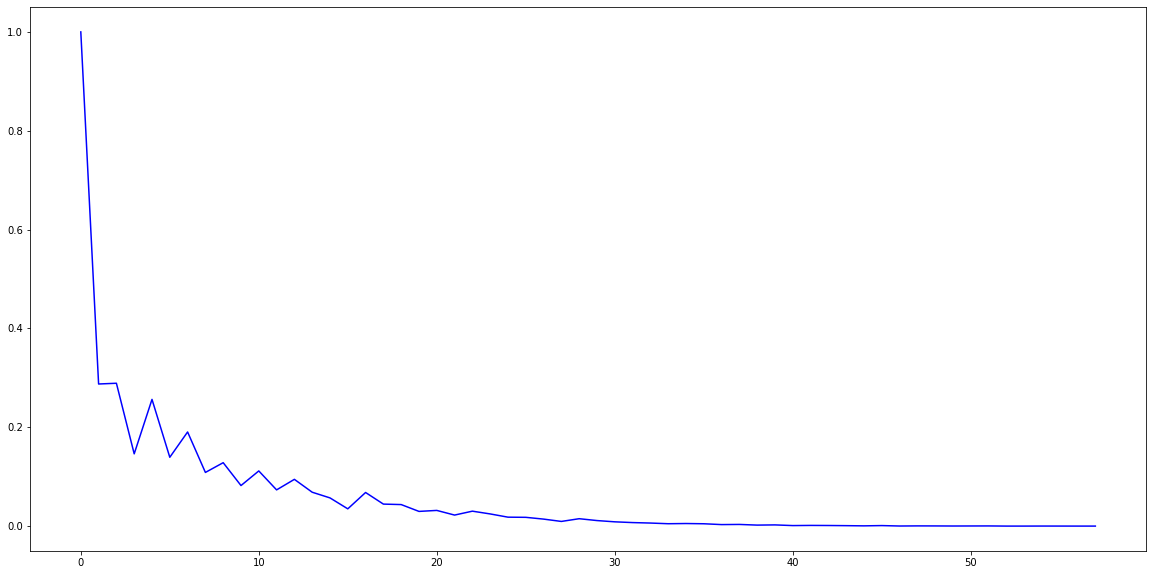

In [55]:
#plot the retention table
plt.figure(figsize=(20,10))
plt.plot(cohort_table.period, cohort_table.pct_retained, color='blue')
plt.show()

BREAKDOWN THE QUERY OVER THERE

In [66]:
%%sql
SELECT 
    id_bioguide,
    min(term_start) as first_term
FROM legislators_terms
GROUP BY 1;

,id_bioguide,first_term
0,F000062,1992-11-10
1,T000464,2007-01-04
2,A000360,2003-01-07
3,G000359,1995-01-04
4,R000307,1981-01-05
...,...,...
12513,R000409,1989-01-03
12514,B000426,1951-01-03
12515,F000445,2001-06-26
12516,J000267,1958-04-19


In [ ]:
%%sql
SELECT 
    date_part('year', AGE(b.term_start, a.first_term)) as period,
    COUNT(DISTINCT a.id_bioguide) as cohort_retained
FROM 
(
    SELECT 
        id_bioguide,
        min(term_start) as first_term
    FROM legislators_terms
    GROUP BY 1
) a
JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
GROUP BY 1;

In [ ]:
SELECT
    period,
    first_value(cohort_retained) over (order by period) as cohort_size,
    cohort_retained,
FROM 
(
    SELECT 
        date_part('year', AGE(b.term_start, a.first_term)) as period,
        COUNT(DISTINCT a.id_bioguide) as cohort_retained
    FROM 
    (
        SELECT 
            id_bioguide,
            min(term_start) as first_term
        FROM legislators_terms
        GROUP BY 1
    ) a
    JOIN legislators_terms b ON a.id_bioguide = b.id_bioguide
    GROUP BY 1   
) aa
;

Another try: still the cohort but you need to have something else

#### HAHA